In [54]:
import pymc3 as pm
from pymc3.glm import glm
import numpy as np
import pandas as pd
import datetime
import scipy.stats

from scipy import optimize
import theano as thno
import theano.tensor as T

# data retrieval helper module
from general.DB import DB
import util

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

In [419]:
def gen_matchups(N, k):
    np.random.seed(12)
    indices = np.array([np.random.choice(range(k), 2, replace=False) for i in range(N)])
    return indices
def make_dummies(idx, k):
    leave_out = k - 1
    M = np.zeros((idx.shape[0] * 2, 2 * (k - 1)))
    for i, pairing in enumerate(idx):
        offset = i * 2
        h, a = pairing[0], pairing[1]
        if h == leave_out:
            for j in range(k - 1):
                M[offset, j] = -1.
                M[offset + 1, (k - 1) + j] = -1.
        else:
            M[offset, h] = 1.
            M[offset + 1, (k - 1) + h] = 1.
        if a == leave_out:
            for j in range(k - 1):
                M[offset + 1, j] = -1.
                M[offset, k - 1 + j] = -1
        else:
            M[offset + 1, a] = 1.
            M[offset, k - 1 + a] = 1.
    return M
def gen_data(X, N, k):
    np.random.seed(12)
    off_coef = np.random.normal(0, 2, k)
    def_coef = np.random.normal(0, 2, k)
    off_coef -= np.mean(off_coef)
    def_coef -= np.mean(def_coef)
    home = 5
    coefs = np.append(off_coef[:k-1], def_coef[:k-1])
    X = np.append(X, np.ones(X.shape[0])[:, np.newaxis], 1)
    mus = np.dot(X, np.append(coefs, 65))
    y = np.random.normal(mus, 4)
    return X, y, mus, off_coef, def_coef

In [440]:
N, k = 100, 3
idx = gen_matchups(N, k)
oidx, didx = idx.ravel(), np.fliplr(idx).ravel()
M = make_dummies(idx, k)
X, y, mus, o, d = gen_data(M, N, k)
res = sm.GLM(y, X).fit()
oidx.shape, y.shape

((200,), (200,))

In [441]:
res = sm.GLM(y, X).fit()
sm_off_coefs = list(res.params[:])
res.summary()

[ 0.49233476  0.48707361  0.48116267  0.49233476  0.48707361  0.48116267
  0.17803848]


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      195
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                   17.3984979257
Method:                          IRLS   Log-Likelihood:                -566.89
Date:                Mon, 09 May 2016   Deviance:                       3392.7
Time:                        15:46:51   Pearson chi2:                 3.39e+03
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2815      0.475      0.593      0.553        -0.649     1.212
x2            -1.1396      0.492     -2.318      0.020        -2.103    -0.176
x3            -2.2194      0.475     -4.675      0.000        -3.150    -1.289
x4             3.4926      0.492      7.105      0.000         2.529     4.456
const         64.2622      0.299    215.256      0.000        63.677    64.847
==============================================================================
"""

In [442]:
with pm.Model() as model:
    off_coefs = pm.Normal('off_coefs', 0, sd=100, shape=k)
    def_coefs = pm.Normal('def_coefs', 0, sd=100, shape=k)
    off_centered = pm.Deterministic('off_centered', off_coefs - T.mean(off_coefs))
    def_centered = pm.Deterministic('def_centered', def_coefs - T.mean(def_coefs))
    std = pm.Uniform('std', 0.01, 20)
#     home = pm.Normal('home', 0, sd=5)
    intercept = pm.Normal('intercept', 50, sd=10)
    
    mus = off_centered[oidx] + def_centered[didx] + intercept
    target = pm.Normal('target', mu=mus, sd=std, observed=y)
    start = pm.find_MAP()
    print(start)
    step1 = pm.NUTS([off_coefs, def_coefs, std, intercept])
    traces = pm.sample(3000, step=step1, start=start, progressbar=True)

Applied interval-transform to std and added transformed std_interval to model.
{'intercept': array(64.24977936394241), 'std_interval': array(-1.34968874760186), 'def_coefs': array([-2.22188184,  3.4935181 , -1.27163627]), 'off_coefs': array([ 0.27900366, -1.13854093,  0.85953727])}
 [-----------------100%-----------------] 3000 of 3000 complete in 60.3 sec

In [219]:
with model:
    traces = pm.sample(3000, step=step1, start=start, progressbar=True)

 [-----------------100%-----------------] 3000 of 3000 complete in 109.1 sec

In [460]:
# history = 1000
# print(o, d)
# _ = pm.traceplot(traces[-history:], figsize=(12, len(traces.varnames) * 1.5))

In [167]:
def get_gaussian(mean, sigma):
    x = np.linspace(mean - 5 * sigma, mean + 5 * sigma, 100)
    return x, mlab.normpdf(x, mean, sigma)

(3, 2)


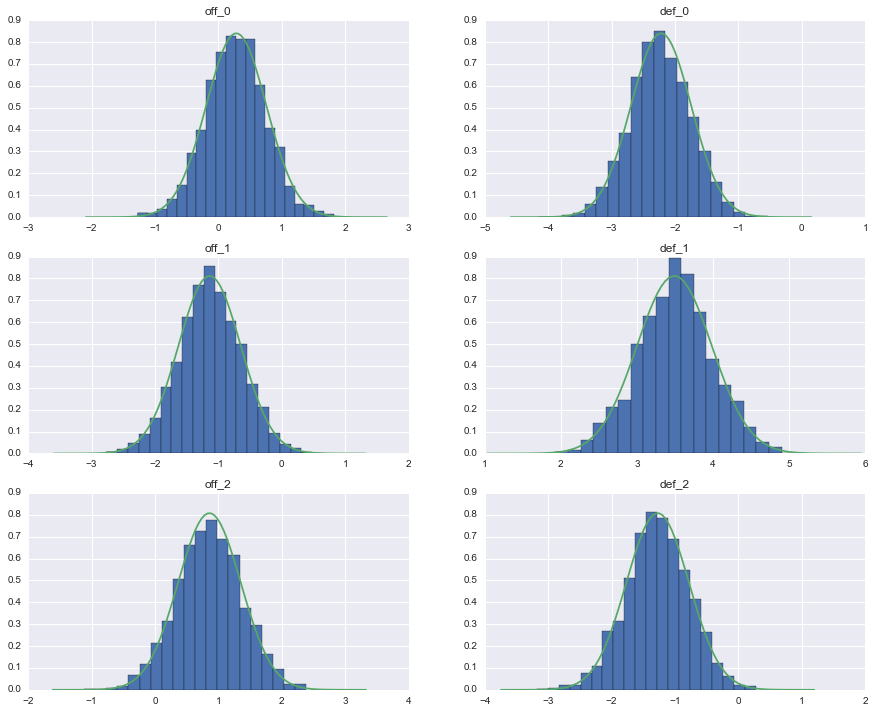

In [473]:
sm_off_coefs = res.params[:k - 1]
sm_off_coefs = np.append(sm_off_coefs, -1 * np.sum(sm_off_coefs))
sm_def_coefs = res.params[k - 1:2 * (k - 1)]
sm_def_coefs = np.append(sm_def_coefs, -1 * np.sum(sm_def_coefs))
mean = sm_off_coefs[-1]
sm_cov = res.cov_params()
sm_off_cov = sm_cov[:k-1, :k-1]
sm_def_cov = sm_cov[k-1:2*(k-1), k-1:2*(k-1)]
sm_off_sigmas = np.sqrt(np.append(sm_off_cov.diagonal(), np.sum(sm_off_cov)))
sm_def_sigmas = np.sqrt(np.append(sm_def_cov.diagonal(), np.sum(sm_def_cov)))

fig, axs = plt.subplots(3, 2, figsize=(15, 12))
print(axs.shape)
for i in range(axs.shape[0]):
    axs[i, 0].hist(traces['off_centered'][:, i], normed=True, bins=20)
    axs[i, 0].set_title('off_%s' % i)
    x, density = get_gaussian(sm_off_coefs[i], sm_off_sigmas[i])
    axs[i, 0].plot(x, density)
    axs[i, 1].hist(traces['def_centered'][:, i], normed=True, bins=20)
    axs[i, 1].set_title('def_%s' % i)
    x, density = get_gaussian(sm_def_coefs[i], sm_def_sigmas[i])
    axs[i, 1].plot(x, density)

In [449]:
res.cov_params()[-1, -1]

0.089125096841067036

0.299464236202 0.178038482507


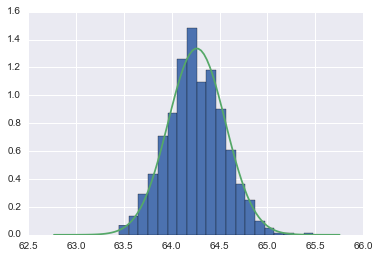

In [474]:
plt.hist(traces[-1000:]['intercept'], normed=True, bins=20)
x, density = get_gaussian(res.params[-1], np.sqrt(res.cov_params()[-1, -1]))
plt.plot(x, density)
print(np.std(traces[-1000:]['intercept']), sigmas[-1])

In [251]:
sigma = sigmas[-1]
sigmao = np.sqrt(np.sum(sigmas[:k]**2) / k**2)
sigmad = np.sqrt(np.sum(sigmas[k:2*k]**2) / k**2)
np.sqrt(sigma**2 + sigmao**2 + sigmad**2)

0.43558170151226472

In [249]:
cov = np.sqrt(np.linalg.pinv(XTX) * sy)
cov.diagonal()

array([ 0.4193465 ,  0.44393037,  0.57241608,  0.600981  ,  0.58258705,
        2.36413066,         nan])

In [256]:
np.dot(X[:, :k].T, X[:, :k])
np.dot(X[:, k:2*k].T, X[:, k:2*k])

array([[ 74.,   0.,   0.],
       [  0.,  70.,   0.],
       [  0.,   0.,  56.]])

In [475]:
pd.DataFrame(res.cov_params())

,0,1,2,3,4
0,0.225387,-0.111468,0.094315,-0.045050,0.018399
1,-0.111468,0.241621,-0.045050,0.129946,-0.007533
2,0.094315,-0.045050,0.225387,-0.111468,0.018399
3,-0.045050,0.129946,-0.111468,0.241621,-0.007533
4,0.018399,-0.007533,0.018399,-0.007533,0.089125


In [499]:
Xc = X - np.mean(X, 0)
y_pred = np.dot(X, res.params)
sy = np.sum((y - y_pred)**2) * 1 / (X.shape[0] - X.shape[1])
pd.DataFrame(np.linalg.pinv(np.dot(X.T, X)) * sy)

,0,1,2,3,4
0,0.225387,-0.111468,0.094315,-0.045050,0.018399
1,-0.111468,0.241621,-0.045050,0.129946,-0.007533
2,0.094315,-0.045050,0.225387,-0.111468,0.018399
3,-0.045050,0.129946,-0.111468,0.241621,-0.007533
4,0.018399,-0.007533,0.018399,-0.007533,0.089125


In [492]:
res.cov_params?

In [279]:
df['oidx'] = oidx
df['didx'] = didx

In [281]:
df.to_csv("/Users/sethhendrickson/ratings_dummy_data.csv", index=False)

In [295]:
ovar = np.sum(C[:k, :k]) * 1 / k**2
dvar = np.sum(C[k:2*k, k:2*k]) * 1 / k**2
ivar = C[6,6]

In [301]:
np.sqrt(np.sum(C) / k**2)

0.17803848250701382

In [312]:
Xp = X - np.mean(X, axis=0)
np.dot(Xp.T, Xp) / N

array([[ 0.4662, -0.259 , -0.2072, -0.2738,  0.181 ,  0.0928,  0.    ],
       [-0.259 ,  0.455 , -0.196 ,  0.181 , -0.245 ,  0.064 ,  0.    ],
       [-0.2072, -0.196 ,  0.4032,  0.0928,  0.064 , -0.1568,  0.    ],
       [-0.2738,  0.181 ,  0.0928,  0.4662, -0.259 , -0.2072,  0.    ],
       [ 0.181 , -0.245 ,  0.064 , -0.259 ,  0.455 , -0.196 ,  0.    ],
       [ 0.0928,  0.064 , -0.1568, -0.2072, -0.196 ,  0.4032,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ]])

In [307]:
np.dot(X.T, X)

array([[  74.,    0.,    0.,    0.,   44.,   30.,   74.],
       [   0.,   70.,    0.,   44.,    0.,   26.,   70.],
       [   0.,    0.,   56.,   30.,   26.,    0.,   56.],
       [   0.,   44.,   30.,   74.,    0.,    0.,   74.],
       [  44.,    0.,   26.,    0.,   70.,    0.,   70.],
       [  30.,   26.,    0.,    0.,    0.,   56.,   56.],
       [  74.,   70.,   56.,   74.,   70.,   56.,  200.]])

In [322]:
pd.DataFrame(np.dot(np.linalg.pinv(X), np.linalg.pinv(X.T))) * 17

,0,1,2,3,4,5,6
0,0.245757,-0.135350,-0.111517,0.142113,-0.095755,-0.047467,-0.001110
1,-0.135350,0.240533,-0.097575,-0.095755,0.129901,-0.026537,0.007608
2,-0.111517,-0.097575,0.234730,-0.047467,-0.026537,0.099643,0.025639
3,0.142113,-0.095755,-0.047467,0.245757,-0.135350,-0.111517,-0.001110
4,-0.095755,0.129901,-0.026537,-0.135350,0.240533,-0.097575,0.007608
5,-0.047467,-0.026537,0.099643,-0.111517,-0.097575,0.234730,0.025639
6,-0.001110,0.007608,0.025639,-0.001110,0.007608,0.025639,0.032138


In [326]:
2.6 * 2  / 3 + -10 / 3

-1.6

In [346]:
Xp = X
Xp[np.where(Xp[:, 2] == 1)[0], 0] = -1
Xp[np.where(Xp[:, 2] == 1)[0], 1] = -1
Xp[np.where(Xp[:, 2] == 1)[0], 2] = 0
Xp[np.where(Xp[:, 5] == 1)[0], 3] = -1
Xp[np.where(Xp[:, 5] == 1)[0], 4] = -1
Xp[np.where(Xp[:, 5] == 1)[0], 5] = 0

In [349]:
res1 = sm.GLM(y, Xp).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      195
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                   15.3242663517
Method:                          IRLS   Log-Likelihood:                -554.20
Date:                Mon, 09 May 2016   Deviance:                       2988.2
Time:                        14:43:25   Pearson chi2:                 2.99e+03
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             2.3943      0.446      5.365      0.000         1.520     3.269
x2            -1.8085      0.463     -3.909      0.000        -2.715    -0.902
const      -4.945e-15   2.68e-15     -1.846      0.065     -1.02e-14  3.04e-16
x3            -2.4503      0.446     -5.491      0.000        -3.325    -1.576
x4             1.2484      0.463      2.699      0.007         0.342     2.155
x5                  0          0        nan        nan             0         0
x6            63.4645      0.279    227.544      0.000        62.918    64.011
==============================================================================
"""

In [363]:
N, k = 100, 3
X, y, mus, oidx, didx, off_coef, def_coef = gen_data(N, k, append_intercept=True)
# X[np.where(X[:, k] == 1)] = X[np.where(X[:, k] == 1)] - 1.0
pd.DataFrame(X).head()

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [364]:
for i in range(X.shape[0]):
    if X[i, k] == 1:
        X[i, k] = 0
        for j in range(k - 1):
            X[i, j] = -1
pd.DataFrame(X).head()

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0
2,-1.0,-1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [369]:
def gen_data(N, k, append_intercept=False):
    np.random.seed(12)
    indices = np.array([np.random.choice(range(k), 2, replace=False) for i in range(N)])
    add = np.arange(2)*k
    X = np.zeros((2 * N, 2 * k))
    oidx, didx = [], []
    for i, j in enumerate(range(0, 2 * N, 2)):
        idx = indices[i]
        X[j, idx + add] = 1
        X[j + 1, idx[::-1] + add] = 1
        oidx += list(idx)
        didx += list(idx[::-1])
    true_coef = np.random.normal(0, 2, 2 * k)
    if append_intercept:
        X = np.append(X, np.ones(X.shape[0])[:, np.newaxis], 1)
        true_coef = np.append(true_coef, 65)
    home = 5
    mus = np.dot(X, true_coef)
    y = np.random.normal(mus, 4)
    off_coef, def_coef = true_coef[:k], true_coef[k:]
    return X, y, mus, np.array(oidx), np.array(didx), off_coef, def_coef

In [413]:
def gen_matchups(N, k):
    np.random.seed(12)
    indices = np.array([np.random.choice(range(k), 2, replace=False) for i in range(N)])
    return indices
def make_dummies(idx, k):
    leave_out = k - 1
    M = np.zeros((idx.shape[0] * 2, 2 * (k - 1)))
    for i, pairing in enumerate(idx):
        offset = i * 2
        h, a = pairing[0], pairing[1]
        if h == leave_out:
            for j in range(k - 1):
                M[offset, j] = -1.
                M[offset + 1, (k - 1) + j] = -1.
        else:
            M[offset, h] = 1.
            M[offset + 1, (k - 1) + h] = 1.
        if a == leave_out:
            for j in range(k - 1):
                M[offset + 1, j] = -1.
                M[offset, k - 1 + j] = -1
        else:
            M[offset + 1, a] = 1.
            M[offset, k - 1 + a] = 1.
    return M
def _concat(O, D):
    return np.append(O, D, axis=1)
def gen_data(X, N, k):
    np.random.seed(12)
    off_coef = np.random.normal(0, 2, k)
    def_coef = np.random.normal(0, 2, k)
    off_coef -= np.mean(off_coef)
    def_coef -= np.mean(def_coef)
    home = 5
    coefs = np.append(off_coef[:k-1], def_coef[:k-1])
    X = np.append(X, np.ones(X.shape[0])[:, np.newaxis], 1)
    mus = np.dot(X, np.append(coefs, 65))
    y = np.random.normal(mus, 4)
    return X, y, mus, off_coef, def_coef
    

In [414]:
idx= gen_matchups(N, k)
M = make_dummies(idx, k)
X, y, mus, o, d = gen_data(M, N, k)
res = sm.GLM(y, X).fit()

In [432]:
idx.ravel()

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2, 0, 1, 1, 0, 2, 1, 1, 2, 2, 0, 0,
       2, 1, 0, 2, 0, 1, 2, 1, 0, 1, 2, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 0, 2,
       2, 1, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 2, 1, 2, 1, 0, 0,
       1, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 0, 2, 2, 1, 0, 1,
       2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 0, 2, 2, 0, 1,
       2, 2, 0, 2, 0, 0, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 0,
       2, 1, 1, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 1, 1, 2, 2, 0, 2, 1, 1, 0, 2,
       1, 2, 1, 1, 0, 0, 1, 1, 2, 1, 0, 2, 1, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1,
       0, 1, 2, 0, 0, 2, 2, 1, 2, 1, 1, 2, 1, 0, 1, 2])

In [439]:
np.fliplr(idx)[:5], idx[:5]

(array([[1, 0],
        [0, 2],
        [2, 1],
        [1, 0],
        [1, 2]]), array([[0, 1],
        [2, 0],
        [1, 2],
        [0, 1],
        [2, 1]]))